In [1]:
import pygplates
import pygmt
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d
#from sklearn.neighbors import KernelDensity
from gprm import PointDistributionOnSphere
from gprm.datasets import Reconstructions, Zircons, Rocks
from gprm.utils.sphere import spherical_kde
from gprm.utils.raster import to_anchor_plate
from gprm import SubductionConvergence
import warnings

import matplotlib as mpl
mpl.rc('font',family='Helvetica')
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2

%load_ext autoreload
%autoreload 2


In [2]:
df_SampleDetails, df_Data = Zircons.loadDB(version=2018)


/opt/anaconda3/envs/pygmt7/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [3]:
SedimentaryZircons = Zircons.get_sedimentary_samples(df_SampleDetails,df_Data)
IgneousZircons = Zircons.get_igneous_samples(df_SampleDetails,df_Data)

In [4]:
sam_mask = gpd.read_file('/Users/simon/GIT/NREE/gis/SAM_zircon_mask.geojson')

sam_Izircons = gpd.clip(IgneousZircons, sam_mask)
sam_Szircons = gpd.clip(SedimentaryZircons, sam_mask)

<AxesSubplot:>

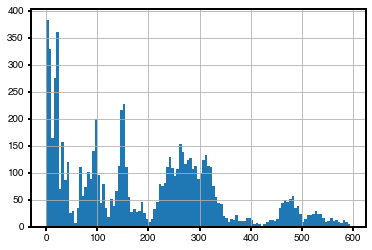

In [5]:
#for reconstruction_time in time_series:
#    subset = IZM[(IZM['206Pb_238U_Age_Ma']>=reconstruction_time) & (IZM['206Pb_238U_Age_Ma']<reconstruction_time+time_step)]
 
sam_Izircons['206Pb_238U_Age_Ma'].hist(bins=np.arange(0,600,5))    

In [6]:
M2019 = Reconstructions.fetch_Muller2019()
M2016 = Reconstructions.fetch_Muller2016()

Cupor = gpd.clip(Rocks.BaseMetalDeposits(deposit_type='Cu-por'), sam_mask)
Cupor = Cupor.replace({'ND': np.nan})

In [7]:
time_series = np.arange(0,121,1)
lat_samples = np.arange(-55,5,0.1)

anchor_plate_id = 201

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc_df = SubductionConvergence(M2019, time_series, np.radians(0.1), anchor_plate_id=anchor_plate_id, velocity_delta_time=1).df
    cr = np.asarray(sc_df['conv_rate'])
    co = np.asarray(sc_df['conv_obliq'])
    sc_df['ortho_conv_rate'] = pd.Series(cr*np.abs(np.cos(np.radians(co))), index=sc_df.index)
    sc_df['sub_area'] = sc_df['ortho_conv_rate'] * 100. * sc_df['arc_length'] * 2 * np.pi * 6371000. / 360.

In [8]:
scc = sc_df[(sc_df.subducting_plate.isin([902,908,919,904,911,985,224,802])) & 
            ((sc_df.overriding_plate==201) | (sc_df.overriding_plate>200000))]

tmp = []
tmpp = []
tmppp = []
area_flux_series = []
volume_flux_series = []
for reconstruction_time in time_series:
    
    print(reconstruction_time)
    subset = scc[scc.time==reconstruction_time]
    subset = subset.sort_values(by='lat').reset_index()
    
    agegrid = to_anchor_plate(
        '/Users/simon/GIT/ghf/Muller_etal_2019_Tectonics_v2.0_netCDF/Muller_etal_2019_Tectonics_v2.0_AgeGrid-{:0.0f}.nc'.format(reconstruction_time),
        M2019, reconstruction_time, new_anchor_plate_id=anchor_plate_id, region=[-85,-50,-65,12], spacing=0.1)

    seafloor_age = pygmt.grdtrack(
                        points=subset[['lon','lat']],
                        grid=agegrid,
                        newcolname='z', radius='200k')
    subset['seafloor_age'] = seafloor_age.z
    
    carbonate_grid = to_anchor_plate(
        '/Users/simon/Data/carbonates/decompacted_sediment_thickness_0.5_{:0.0f}.nc'.format(reconstruction_time),
        M2016, reconstruction_time, new_anchor_plate_id=anchor_plate_id, region=[-85,-50,-65,12], spacing=0.25)

    carbonate_thickness = pygmt.grdtrack(
                        points=subset[['lon','lat']],
                        grid=carbonate_grid,
                        newcolname='z', radius='200k')
    subset['carbonate_thickness'] = carbonate_thickness.z
    
    zi = np.interp(lat_samples, seafloor_age.lat, seafloor_age.z, left=np.nan, right=np.nan)
    tmp.append(zi)
    
    zi = np.interp(lat_samples, subset.lat, subset.ortho_conv_rate, left=np.nan, right=np.nan)
    tmpp.append(zi)
    
    zi = np.interp(lat_samples, carbonate_thickness.lat, carbonate_thickness.z, left=np.nan, right=np.nan)
    tmppp.append(zi)
    
    subset_latitude_limited = subset[(subset.lat>lat_samples.min()) & (subset.lat<lat_samples.max())]
    area_flux = subset_latitude_limited['ortho_conv_rate'] * 100. * subset_latitude_limited['arc_length'] * 2 * np.pi * 6371000. / 360.
    volume_flux = area_flux * np.sqrt(subset_latitude_limited.seafloor_age) * 10.  # UNITS????
    area_flux_series.append(area_flux.sum())
    volume_flux_series.append(np.nansum(volume_flux))


age_array = np.vstack(tmp).T
conv_array = np.vstack(tmpp).T
carbonate_array = np.vstack(tmppp).T
#flux_array = conv_array*age_array


0


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


1


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


2


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


3


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


4


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


5


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


6


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


7


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


8


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


9


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


10


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


11


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


12


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


13


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


14


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


15


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


16


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


17


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


18


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


19


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


20


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


21


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


22


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


23


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


24


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


25


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


26


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


27


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


28


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


29


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


30


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


31


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


32


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


33


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


34


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


35


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


36


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


37


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


38


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


39


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


40


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


41


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


42


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


43


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


44


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


45


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


46


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


47


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


48


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


49


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


50


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70


/opt/anaconda3/envs/pygmt7/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120


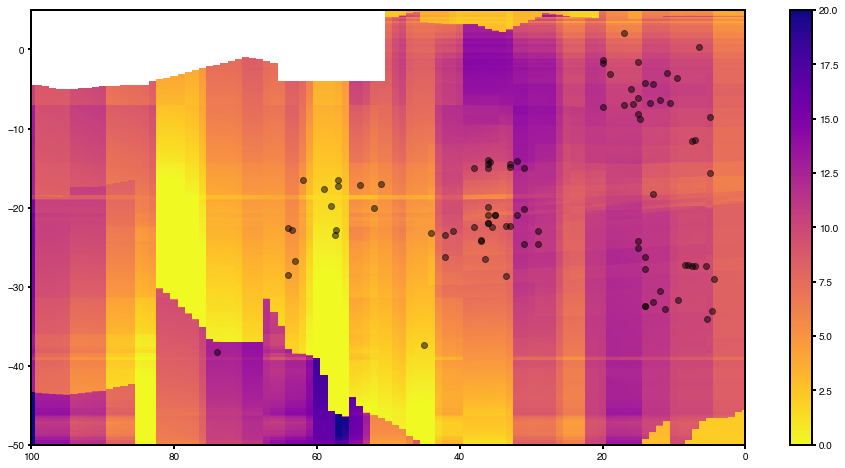

In [9]:
plt.figure(figsize=(16,8))
plt.pcolormesh(time_series, 
               lat_samples, 
               conv_array, 
               vmin=0, vmax=20, cmap='plasma_r')
plt.plot(Cupor.Age, Cupor.geometry.y, 'ko', alpha=0.5)
#plt.plot(sam_Izircons['206Pb_238U_Age_Ma']+15, sam_Izircons.geometry.y, 'ko', alpha=0.2)
plt.xlim(100,0)
plt.ylim(-50,5)
plt.colorbar()

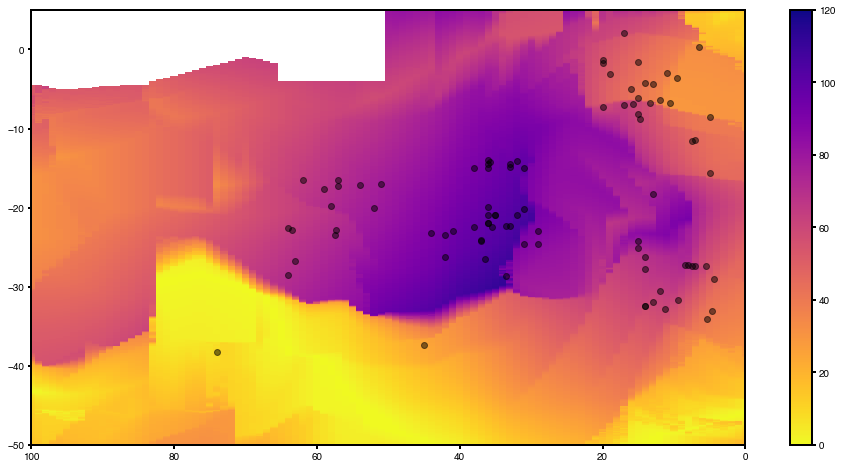

In [10]:
plt.figure(figsize=(16,8))
plt.pcolormesh(time_series, 
               lat_samples, 
               age_array, 
               vmin=0, vmax=120, cmap='plasma_r')
plt.plot(Cupor.Age, Cupor.geometry.y, 'ko', alpha=0.5)
#plt.plot(sam_Izircons['206Pb_238U_Age_Ma']+15, sam_Izircons.geometry.y, 'ko', alpha=0.2)
plt.xlim(100,0)
plt.ylim(-50,5)
plt.colorbar()

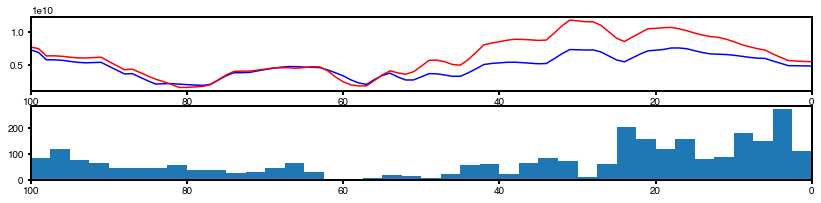

In [11]:
fig,ax = plt.subplots(nrows=2, figsize=(14,3))
N=3
ax[0].plot(time_series, uniform_filter1d(area_flux_series, size=N), 'b')
ax[0].plot(time_series, uniform_filter1d(np.array(volume_flux_series)/50., size=N), 'r')
#ax[0].plot(time_series-15, uniform_filter1d(area_flux_series, size=N), 'b:')
#ax[0].plot(time_series-15, uniform_filter1d(np.array(volume_flux_series)/50., size=N), 'r:')
ax[0].set_xlim(100,0)
ax[1].hist(sam_Izircons['206Pb_238U_Age_Ma'], bins=np.arange(0,120,2.5))
#ax[1].hist(sam_Szircons['206Pb_238U_Age_Ma'], bins=np.arange(0,120,2.5), alpha=0.6)
ax[1].set_xlim(100,0)
plt.show()


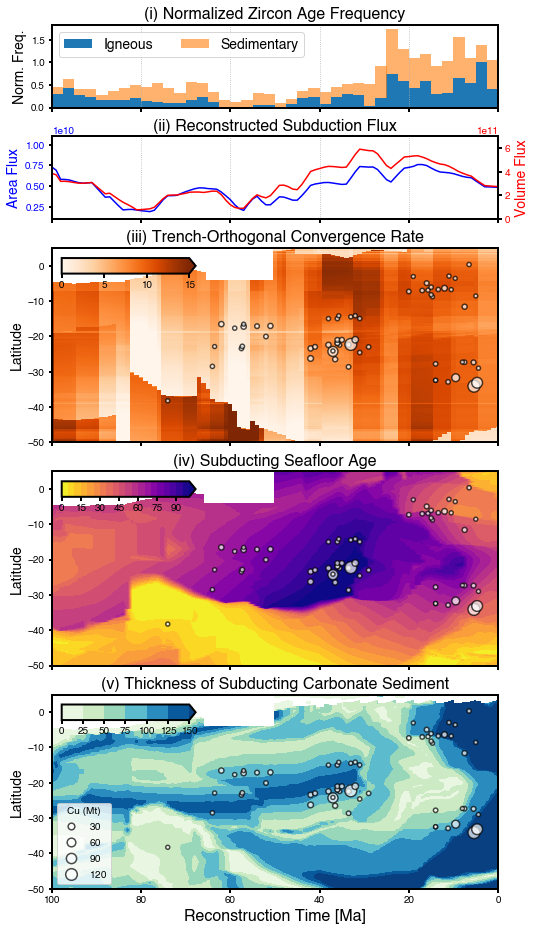

In [13]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def plot_Cu(ax, Cupor):
    Cupor = Cupor.dropna(subset=['Cu (Mt)'])
    #cu_scatter = ax.scatter(Cupor.Age, Cupor.geometry.y, s=(np.sqrt(Cupor['Cu (Mt)'])*10)+20, color='w', alpha=0.7, edgecolors='k', linewidth=1.5, label='Cu (Mt)')
    cu_scatter = ax.scatter(Cupor.Age, Cupor.geometry.y, s=Cupor['Cu (Mt)']+15, color='w', alpha=0.7, edgecolors='k', linewidth=1.5, label='Cu (Mt)')
    #ax.scatter(Cupor.Age, Cupor.geometry.y, s=np.sqrt(s)*10, color='k', alpha=0.7)
    return cu_scatter

ylabel_fontsize = 14
title_fontsize = 16

#################################################
fig = plt.figure(figsize=(8,20))
gs = fig.add_gridspec(nrows=10, ncols=1, wspace=0.2, hspace=.35)

ax = fig.add_subplot(gs[0, 0])
#ax.hist(sam_Izircons['206Pb_238U_Age_Ma'], bins=np.arange(0,120,2.5))
#ax.hist(sam_Szircons['206Pb_238U_Age_Ma'], bins=np.arange(0,120,2.5), alpha=0.3)
binsize = 2.5
igneous_histogram, bin_edges = np.histogram(sam_Izircons['206Pb_238U_Age_Ma'], bins=np.arange(0,120,binsize))
igneous_histogram = igneous_histogram / np.max(igneous_histogram)
ax.bar(bin_edges[:-1], igneous_histogram, align='edge', width=binsize, label='Igneous')
sedimentary_histogram, bin_edges = np.histogram(sam_Szircons['206Pb_238U_Age_Ma'], bins=np.arange(0,120,binsize))
sedimentary_histogram = sedimentary_histogram / np.max(sedimentary_histogram)
ax.bar(bin_edges[:-1], sedimentary_histogram, align='edge', width=binsize, bottom=igneous_histogram, alpha=0.6, label='Sedimentary')
ax.legend(ncol=2, fontsize=ylabel_fontsize)
#IZhist = IZhist/np.max()
ax.set_xlim(100,0)
ax.grid(axis='x', linestyle=':')
ax.set_xticklabels([])
ax.set_ylabel('Norm. Freq.', fontsize=ylabel_fontsize)
ax.set_title('(i) Normalized Zircon Age Frequency', fontsize=title_fontsize)


#################################################
ax = fig.add_subplot(gs[1, 0])
N=3
ax.plot(time_series, uniform_filter1d(area_flux_series, size=N), 'b', label='area flux')
ax.set_xlim(100,0)
ax.set_ylim(1e9,11e9)
ax.grid(axis='x', linestyle=':')
ax.set_xticklabels([])
ax.set_ylabel('Area Flux', fontsize=ylabel_fontsize, color='b')
ax.tick_params(axis='y', labelcolor='b')

ax1 = ax.twinx() 
ax1.plot(time_series, uniform_filter1d(np.array(volume_flux_series), size=N), 'r', label='volume flux')
ax1.set_ylabel('Volume Flux', fontsize=ylabel_fontsize, color='r')
ax1.set_ylim(0e11,7e11)
ax1.tick_params(axis='y', labelcolor='r')
#ax.legend()
ax.set_title('(ii) Reconstructed Subduction Flux', fontsize=title_fontsize)


#################################################
ax = fig.add_subplot(gs[2:4, 0])
m = ax.pcolormesh(time_series, 
               lat_samples, 
               conv_array, 
               vmin=0, vmax=15, cmap='Oranges')
cax = inset_axes(ax, width="30%", height="8%", loc='upper left', borderpad=1)
fig.colorbar(m, cax=cax, orientation="horizontal", extend='max')
cax.xaxis.set_ticks_position("bottom")

cu_scatter = plot_Cu(ax, Cupor)
#plt.plot(sam_Izircons['206Pb_238U_Age_Ma']+15, sam_Izircons.geometry.y, 'bo', alpha=0.1)
ax.set_xlim(100,0)
ax.set_ylim(-50,5)
ax.set_ylabel('Latitude', fontsize=ylabel_fontsize)
#ax.grid()
ax.set_xticklabels([])
ax.set_title('(iii) Trench-Orthogonal Convergence Rate', fontsize=title_fontsize)


#################################################
ax = fig.add_subplot(gs[4:6, 0])
#ax.pcolormesh(time_series, 
#               lat_samples, 
#               age_array, 
#               vmin=0, vmax=120, cmap='plasma_r')
m = ax.contourf(time_series, 
               lat_samples, 
               age_array, 
               levels=np.arange(0,101,5), cmap='plasma_r', extend='max')
cax = inset_axes(ax, width="30%", height="8%", loc='upper left', borderpad=1)
fig.colorbar(m, cax=cax, orientation="horizontal")
cax.xaxis.set_ticks_position("bottom")

cu_scatter = plot_Cu(ax, Cupor)
#plt.plot(sam_Izircons['206Pb_238U_Age_Ma']+15, sam_Izircons.geometry.y, 'ko', alpha=0.2)
ax.set_xlim(100,0)
ax.set_ylim(-50,5)
ax.set_ylabel('Latitude', fontsize=ylabel_fontsize)
#ax.grid()
ax.set_xticklabels([])
ax.set_title('(iv) Subducting Seafloor Age', fontsize=title_fontsize)


#################################################
ax = fig.add_subplot(gs[6:8, 0])
#ax.pcolormesh(time_series, 
#               lat_samples, 
#               carbonate_array, 
#               vmin=0, vmax=150, cmap='GnBu')
m = ax.contourf(time_series, 
               lat_samples, 
               carbonate_array, 
               levels=[0,25,50,75,100,125,150], vmax=150, cmap='GnBu', extend='max')
cax = inset_axes(ax, width="30%", height="8%", loc='upper left', borderpad=1)
fig.colorbar(m, cax=cax, orientation="horizontal")
cax.xaxis.set_ticks_position("bottom")

cu_scatter = plot_Cu(ax, Cupor)
#plt.plot(sam_Izircons['206Pb_238U_Age_Ma']+15, sam_Izircons.geometry.y, 'ko', alpha=0.2)
ax.set_xlim(100,0)
ax.set_ylim(-50,5)
ax.set_ylabel('Latitude', fontsize=ylabel_fontsize)
#ax.grid()
ax.set_title('(v) Thickness of Subducting Carbonate Sediment', fontsize=title_fontsize)

ax.set_xlabel('Reconstruction Time [Ma]', fontsize=16)


kw = dict(prop="sizes", num=5, color='white', markeredgecolor='black',#fmt="{x:.2f}",
          func=lambda s: s-15 #np.sqrt(s/.3)/3
         )
legend2 = ax.legend(*cu_scatter.legend_elements(**kw),
                    loc="lower left", title="Cu (Mt)")
#ax.legend(*cu_scatter.legend_elements("sizes", num=4), loc = 'lower left')
#ax.legend(loc="lower left")
plt.savefig('./AndesTimeLatitudePlot.pdf')
plt.show()
